In [1]:
#All my imports here
import os
import cv2
import time
import ctypes
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split     
from sklearn.utils.class_weight import compute_class_weight                    
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [2]:
print("Built with CUDA:", tensorflow.test.is_built_with_cuda())  # likely False
print("GPUs:", tensorflow.config.list_physical_devices("GPU"))   # definitely []
try:
    ctypes.CDLL("cudnn64_8.dll")
    print("✅ cudnn64_8.dll loaded")
except OSError as e:
    print("❌ cudnn64_8.dll load error:", e)

Built with CUDA: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ cudnn64_8.dll loaded


In [3]:
print(tensorflow.config.list_physical_devices('GPU'))
print("PATH:", os.environ.get("PATH"))
print("Built with CUDA:", tensorflow.test.is_built_with_cuda())
print("TF expects CUDA:", tensorflow.sysconfig.get_build_info()["cuda_version"])
print("TF expects cuDNN:", tensorflow.sysconfig.get_build_info()["cudnn_version"])
print("GPUs:", tensorflow.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PATH: C:\Users\valen\Desktop\PlantCNN\.venv-py310\Lib\site-packages\cv2\../../x64/vc14/bin;c:\Users\valen\Desktop\PlantCNN\.venv-py310\Scripts;C:\Users\valen\Desktop\PlantCNN\.venv-py310\Scripts;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\libnvvp;C:\Program Files\Common Files\Oracle\Java\javapath;D:\Oculus\Support\oculus-runtime;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\ProgramData\chocolatey\bin;C:\Program Files\php-8.3.2;C:\Users\valen\AppData\Roaming\nvm;C:\Program Files\nodejs;C:\Program Files\NVIDIA Corporation\NVIDIA app\NvDLISR;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Users\valen\AppData\Local\Programs\Python

# Print Overview – Print the shape of the data and the proportion of each class.

In [4]:
#Load and pickle the data. I am displaying the filesize here to make it easy to confirm that the whole file uploaded
images = np.load("./data/images.npy", allow_pickle=True)

print("file size:", os.path.getsize("./data/images.npy"), "bytes")
print("Loaded images shape:", images.shape)


#Remove the row that lables the labels CSV as labels to assure that the images and labels counts are the same QOL change
labels = pd.read_csv("./data/labels.csv", header=None, names=["label"])
labels = labels[labels.label != "Label"].reset_index(drop=True)

assert images.shape[0] == len(labels), "images must equal #labels" #adding an assert here as these must be equal for the data to map correcly


#Print Overview – Print the shape of the data and the proportion of each class.
print("labels: ", len(labels))
print("images: ", images.shape[0])
print("number of classes:", labels.label.nunique())

dist = labels.label.value_counts().sort_index()
prop = dist / dist.sum()
overview = pd.DataFrame({"count": dist, "proportion": prop})
print("\nClass distribution:\n", overview)

file size: 233472128 bytes
Loaded images shape: (4750, 128, 128, 3)
labels:  4750
images:  4750
number of classes: 12

Class distribution:
                            count  proportion
label                                       
Black-grass                  263    0.055368
Charlock                     390    0.082105
Cleavers                     287    0.060421
Common Chickweed             611    0.128632
Common wheat                 221    0.046526
Fat Hen                      475    0.100000
Loose Silky-bent             654    0.137684
Maize                        221    0.046526
Scentless Mayweed            516    0.108632
Shepherds Purse              231    0.048632
Small-flowered Cranesbill    496    0.104421
Sugar beet                   385    0.081053


# Plot Images – Plot sample images from each class with labels.

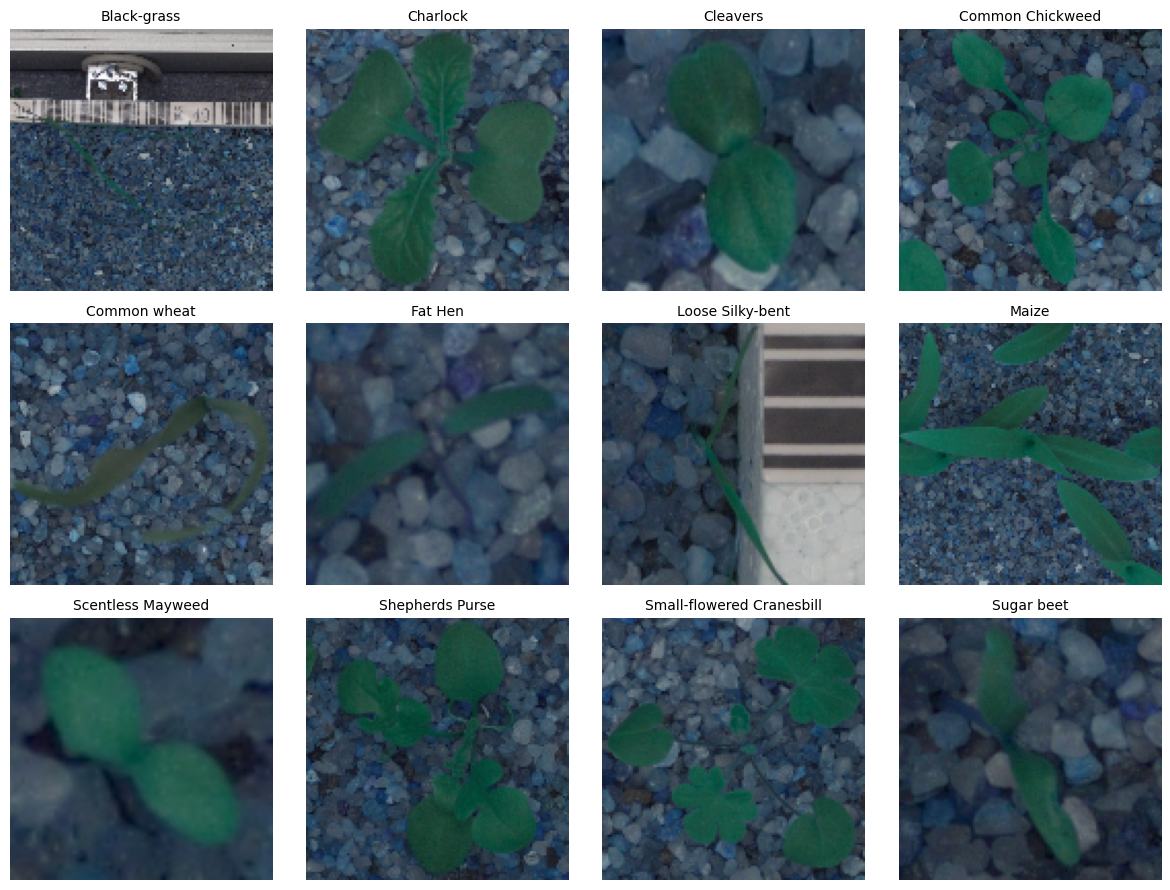

In [20]:
#Defining labels and classes to be used later for ploting images and classes
label_series = labels["label"]
classes = sorted(label_series.unique())

# Map the ids and an image. Using random here just to see new data each time its ran, helps me with debugging
example_idxs = [ #Takes and maps a random image from each of the classes to be displayed below
    np.random.choice(np.where(label_series == cls)[0])
    for cls in classes
]

#Here we are just defining the grid and layout for the images
n = len(classes)
cols = 4
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for ax, idx, cls in zip(axes.flat, example_idxs, classes):
    ax.imshow(images[idx])
    ax.set_title(cls, fontsize=10)
    ax.axis("off")

for ax in axes.flat[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Count Plot – Plot the count of each category to understand class distribution.

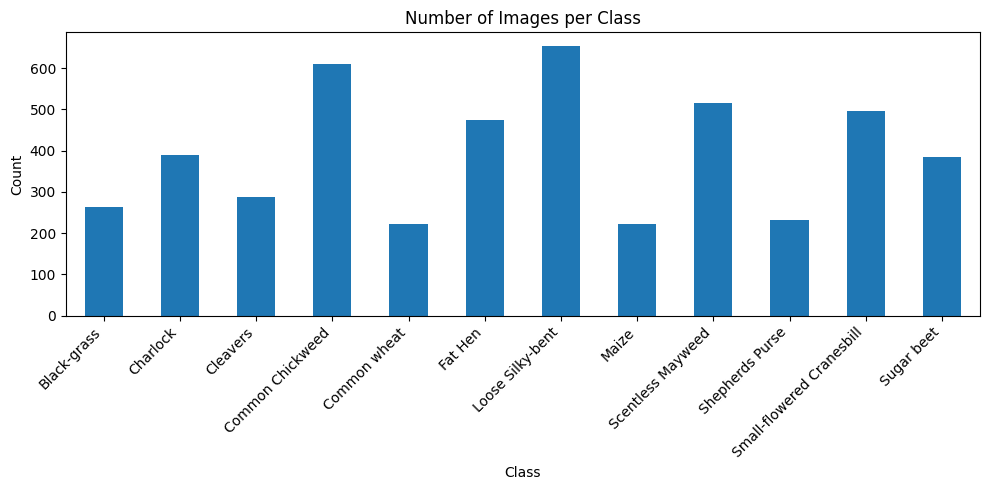

In [6]:
# Get the count for each class
counts = label_series.value_counts().sort_index()

# use matplotlib to create a bar chart for each of the counts
plt.figure(figsize=(10, 5))
counts.plot.bar()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Number of Images per Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Deep Dive – Additional visualizations

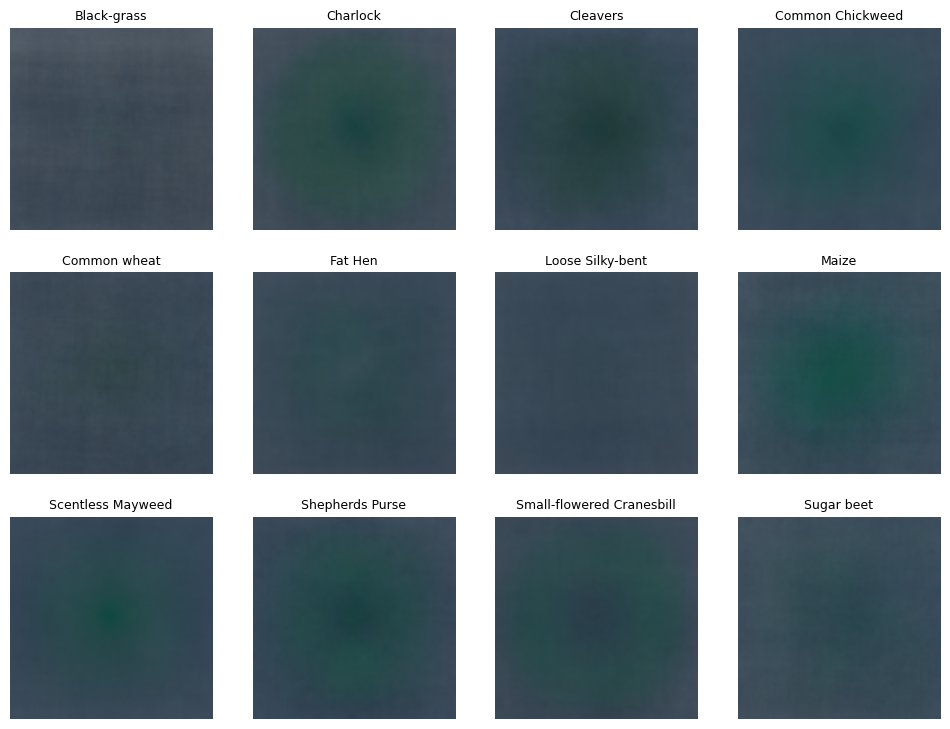

In [7]:
#Just to show additional info here we are averaging the images for each class and displaying it. This kinda shows the patterns each seedling has and what the model might recognize
avg_images = []
for cls in classes:
    idxs = np.where(label_series == cls)[0]
    avg = images[idxs].mean(axis=0)
    avg_images.append(avg.astype(images.dtype))

# defining the display by iterating through the classes
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
for ax, avg_img, cls in zip(axes.flat, avg_images, classes):
    ax.imshow(avg_img)
    ax.set_title(cls, fontsize=9)
    ax.axis("off")

for ax in axes.flat[len(classes):]:
    ax.axis("off")

plt.show()


# EDA Notes:
Classes like the loose Silk-bent, black grass, and Sugar beet do not look good under the image averaging. This is because these plants are thin and the background takes over primarily when averaged out. The ring pattern you see in the images above are artifacts of the images of the seedlings beeing taken from multiple angles or rotated. This should help train the model on learning when plants are in different orientations.

# Noise Removal – Apply Gaussian Blurring

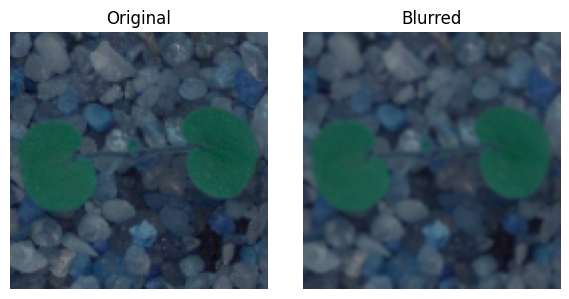

In [8]:
# Apply Gaussian blur to all images here we are setting the kernal size to 3
def apply_gaussian_blur(img_array, ksize=9):
    blurred = np.empty_like(img_array)
    for i in range(len(img_array)):
        blurred[i] = cv2.GaussianBlur(img_array[i], (ksize, ksize), 0)
    return blurred

# Use the bluf function
images_blurred = apply_gaussian_blur(images, ksize=3)

# Check the effect
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(images[0])
axes[0].set_title("Original")
axes[1].imshow(images_blurred[0])
axes[1].set_title("Blurred")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()


# Normalization – Normalize images to a range of 0-1.

In [9]:
images_normalized = images_blurred.astype("float32") / 255.0

# Helps to verify the new range is now 0 to 1
print("Min:", images_normalized.min(), "Max:", images_normalized.max())
print("Image array dtype:", images_normalized.dtype)
print("Pixel range → min:", images_normalized.min(), "max:", images_normalized.max())

Min: 0.0 Max: 1.0
Image array dtype: float32
Pixel range → min: 0.0 max: 1.0


# Visualization – Plot images before and after preprocessing

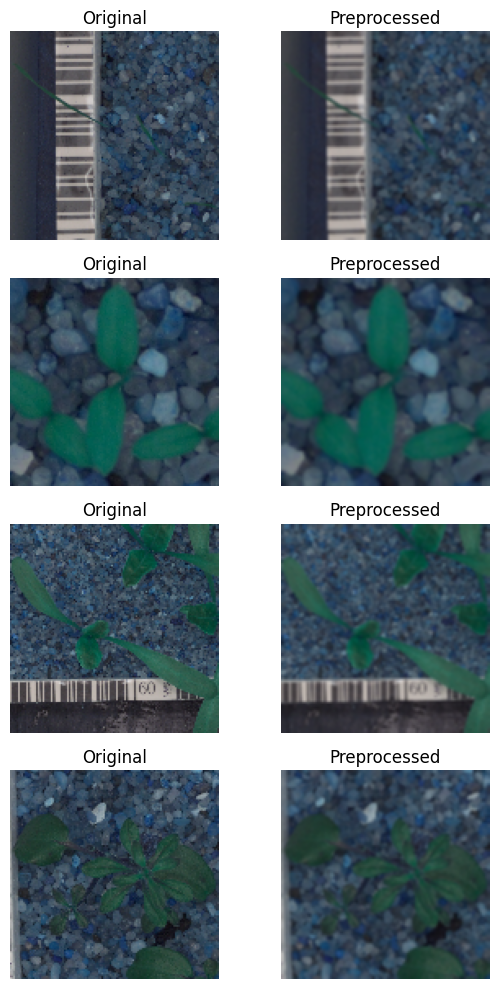

In [10]:
# Pick a few random indexes to display for the preprocessing
import numpy as np
sample_idxs = np.random.choice(len(images), 4, replace=False)

# here we are just defiining the display plot
fig, axes = plt.subplots(len(sample_idxs), 2, figsize=(6, 10))

for i, idx in enumerate(sample_idxs):
    axes[i, 0].imshow(images[idx])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(images_normalized[idx])  # this is after blur and normalization
    axes[i, 1].set_title("Preprocessed")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Split Data – Split data into training and testing sets

In [11]:
# Convert labels to numpy array to make it easier to work with
labels_np = label_series.to_numpy()

# 80% train, 20% test split for the data
X_train, X_test, y_train, y_test = train_test_split(
    images_normalized, labels_np, test_size=0.2, stratify=labels_np, random_state=42
)

# Log shapes
print("Training images:", X_train.shape)
print("Training labels:", y_train.shape)
print("Testing images:", X_test.shape)
print("Testing labels:", y_test.shape)

Training images: (3800, 128, 128, 3)
Training labels: (3800,)
Testing images: (950, 128, 128, 3)
Testing labels: (950,)


# One-Hot Encoding

In [12]:
#convert class names to integer indices where a 1 represents that id and a 0 does not.
encoder = LabelEncoder()
y_train_int = encoder.fit_transform(y_train)
y_test_int = encoder.transform(y_test)

#One-hot encode the values
y_train_ohe = to_categorical(y_train_int)
y_test_ohe = to_categorical(y_test_int)

#display the shape to verify there has been no change
print("One-hot train labels:", y_train_ohe.shape)
print("One-hot test labels:", y_test_ohe.shape)

One-hot train labels: (3800, 12)
One-hot test labels: (950, 12)


# Reshape Data – Ensure data shape is compatible with Keras models

In [ ]:
# Confirm shape of input data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# CNN Model – Build a CNN with appropriate layers

In [13]:
input_shape = X_train.shape[1:]
num_classes = y_train_ohe.shape[1]

model = Sequential([
    Input(shape=input_shape),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(num_classes, activation='softmax', dtype='float32')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

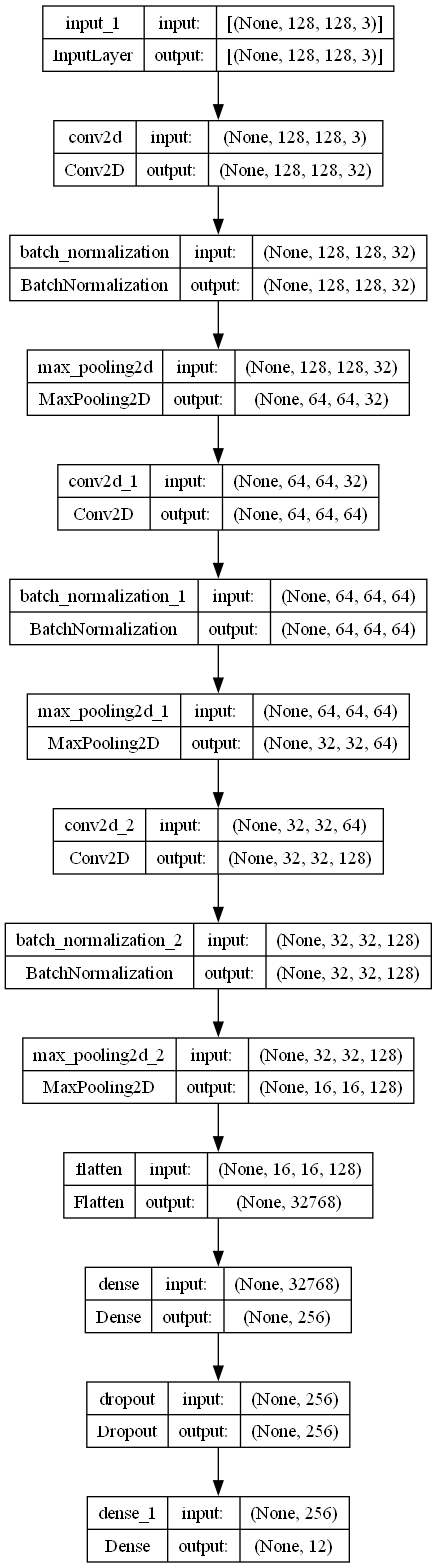

In [14]:
# Save model architecture to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image('model_architecture.png')

# Plot Training History – Visualize the training and validation accuracy and loss.

In [15]:
def plot_training_history(history_obj, title_prefix=""):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # here we are outputting the accuracy plot from based on the history of the CNN run
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Same as above but for the loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Fit Model – Train the CNN model with training data.

In [16]:
# Complile the CNN
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',   # this is used because of the hot encoded ids
    metrics=['accuracy']
)

# Create an image data generator with augmentation to avoid overfitting to similar images

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

start_time = time.time() #I added this just to track CNN training time while modifying parameters for debugging

early_stop = EarlyStopping(
    monitor='val_loss',       # stop if validation loss stops improving
    patience=25,               # wait 13 tries before stopping
    restore_best_weights=True  # go back to best model if other models preform worse
)

# Here we start the training I chose 32 epochs as it seemed to allow for the model to get best results and is large enough that the loss stop may activate
history = model.fit(
    X_train, y_train_ohe,
    validation_data=(X_test, y_test_ohe),
    epochs=96,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

end_time = time.time()
duration = end_time - start_time

print(f"\nTraining completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Epoch 1/96
119/119 [==============================] - 4s 18ms/step - loss: 4.4354 - accuracy: 0.2011 - val_loss: 24.2904 - val_accuracy: 0.0589
Epoch 2/96
119/119 [==============================] - 2s 15ms/step - loss: 2.1749 - accuracy: 0.2532 - val_loss: 8.8798 - val_accuracy: 0.0600
Epoch 3/96
119/119 [==============================] - 2s 15ms/step - loss: 2.0163 - accuracy: 0.3045 - val_loss: 3.6300 - val_accuracy: 0.1747
Epoch 4/96
119/119 [==============================] - 2s 15ms/step - loss: 1.8939 - accuracy: 0.3442 - val_loss: 2.4028 - val_accuracy: 0.3347
Epoch 5/96
119/119 [==============================] - 2s 15ms/step - loss: 1.8256 - accuracy: 0.3708 - val_loss: 2.0614 - val_accuracy: 0.4053
Epoch 6/96
119/119 [==============================] - 2s 15ms/step - loss: 1.7395 - accuracy: 0.4037 - val_loss: 1.4783 - val_accuracy: 0.5179
Epoch 7/96
119/119 [==============================] - 2s 15ms/step - loss: 1.6333 - accuracy: 0.4253 - val_loss: 1.5054 - val_accuracy: 0.558

# Plot Training History – Visualize the training and validation accuracy and loss.


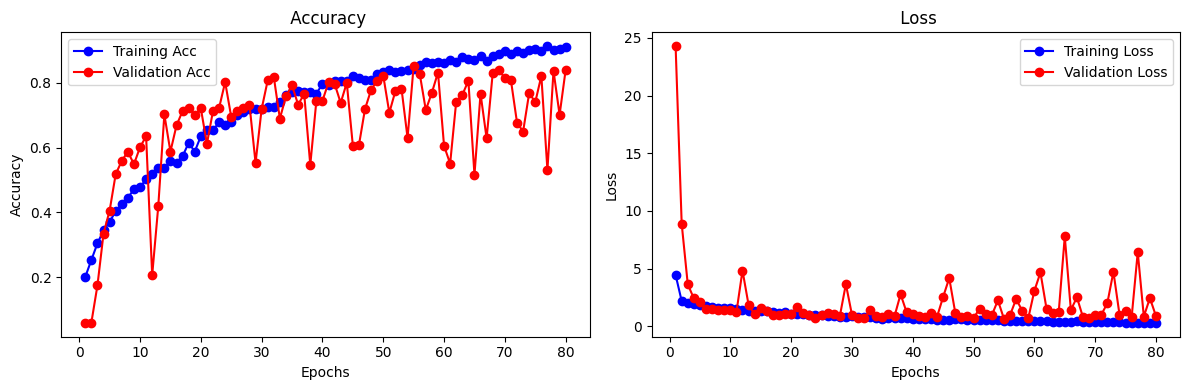

In [17]:
plot_training_history(history)

# Evaluate Model – Evaluate the model on the test set using various metrics

In [18]:
# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert hot vectors to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

30/30 [==============================] - 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.42      0.51        53
           1       0.87      0.96      0.91        78
           2       0.94      0.81      0.87        58
           3       0.98      0.85      0.91       122
           4       0.95      0.82      0.88        44
           5       0.96      0.92      0.94        95
           6       0.77      0.91      0.84       131
           7       0.83      0.98      0.90        44
           8       0.71      0.93      0.80       103
           9       0.60      0.59      0.59        46
          10       0.96      0.91      0.93        99
          11       0.98      0.83      0.90        77

    accuracy                           0.85       950
   macro avg       0.85      0.83      0.83       950
weighted avg       0.86      0.85      0.85       950



# Confusion Matrix – Plot the confusion matrix for model predictions.

0: Black-grass
1: Charlock
2: Cleavers
3: Common Chickweed
4: Common wheat
5: Fat Hen
6: Loose Silky-bent
7: Maize
8: Scentless Mayweed
9: Shepherds Purse
10: Small-flowered Cranesbill
11: Sugar beet


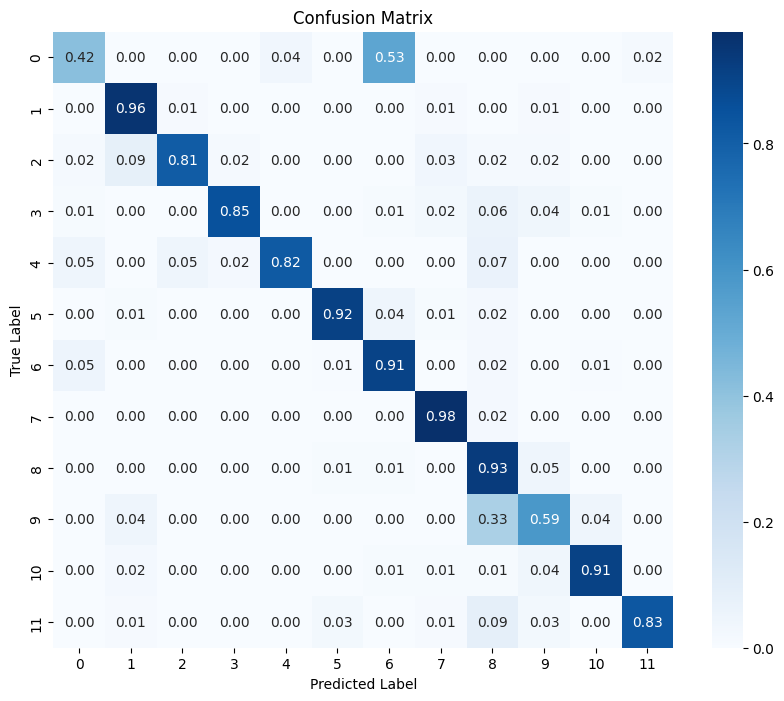

In [19]:
#Display the class -> seedling map to make comparing to the chart easier
label_encoder = LabelEncoder()
label_encoder.fit(labels['label'])

for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{idx}: {class_name}")


# Here we just plot confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
model.save('plant_classifier_v1.h5')